In [1]:
import numpy as np
import upsetplot
import matplotlib.pyplot as plt
import pandas as pd
import utils
import matplotlib.pyplot as plt
import matplotlib as mpl
import copy
from collections import defaultdict


In [3]:
# Results files
UPSETPLOT = '../Results/upsetplot.svg'
DIST_PLOT = lambda cond: f'../Results/Figures/quant_plot.svg'
IDENTIFIED_XLSX = '../Results/identified_FOMOnet.xlsx'

# Input files
DIANN_QUANT = lambda cond: f'../Results/renamed_fomonet_protein_groups_quant_{cond}.tsv'
MSSTATS_QUANT = '../Results/msstats_quant_protein.tsv'
UNIQUES = '../Results/unique_fomonet_id.txt' # Identified pg with only fomonet id

# Params
CONDITIONS = ['ctr', 'hyp', 'rep']
ALLOWED_NA = 0

# Load list of FOMOnet predictions ids
with open(UNIQUES, 'r') as f:
    unique_ids = [line.strip() for line in f.readlines()]

In [4]:
# Replicate to use when processing with dia-nn normalized quants
rep_of_interest = {"ctr": [3, 4, 5],
                   "hyp": [2, 5, 6],
                   "rep": [2, 6, 7]}

### Extract normalized quantification data

In [9]:
# DIA-NN normalized quant
# pg_dict = utils.extract_diann_quant(DIANN_QUANT, rep_of_interest, CONDITIONS, ALLOWED_NA)
# MSstats normalized quant
pg_dict = utils.extract_msstats_quant(MSSTATS_QUANT, CONDITIONS, ALLOWED_NA)

is_unique_fomonet = utils.get_fomonet_pg(pg_dict, unique_ids)
is_unique_cond = utils.get_condition_unique_pg(pg_dict)

### Make quantification distribution plots

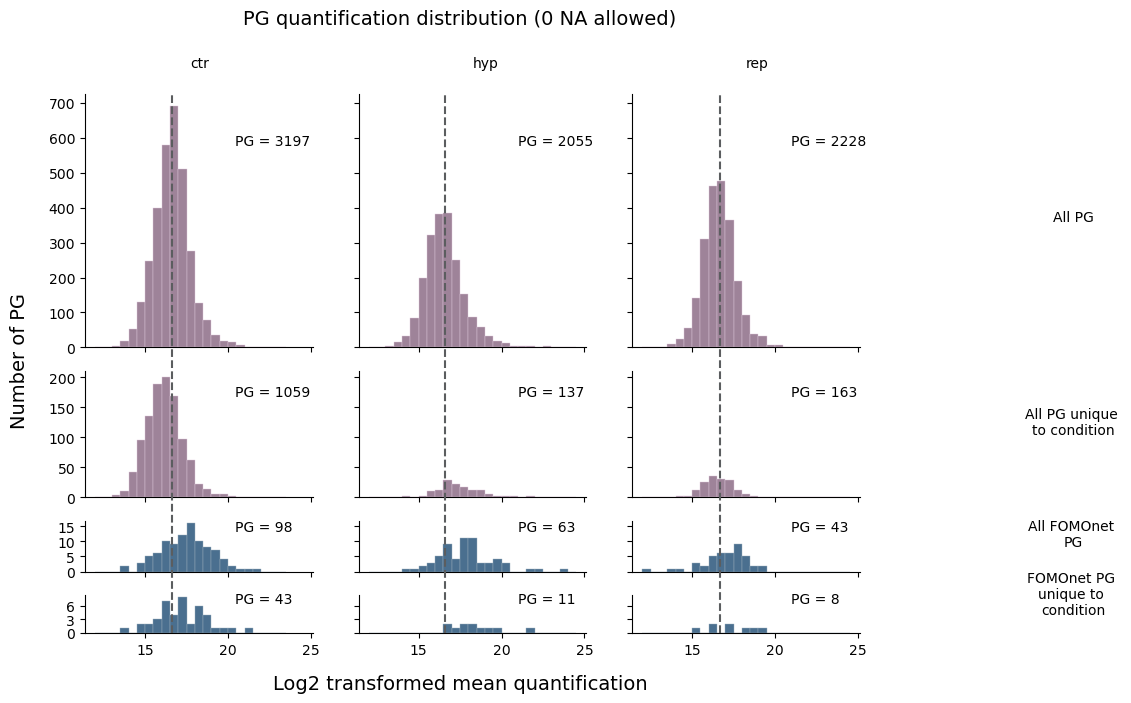

In [10]:
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

# Create plot for each conditions
fig, ax = plt.subplots(4, 3, figsize=(10, 7),
                            gridspec_kw={'height_ratios': [1, .5, 0.2, 0.15]},
                            sharex=True, sharey='row')

for count, cond in enumerate(CONDITIONS):
    # Determine bin size
    log2_quants = pg_dict[cond]['quants']
    min_bin = int(np.min(log2_quants))
    max_bin = int(np.max(log2_quants)) + 1
    bins = np.arange(min_bin, max_bin, 0.5)
    
    # Quant distribution for all PG identified
    data = log2_quants
    ax[0][count].hist(data, 
                      bins=bins,
                      color = '#9E8399', 
                      edgecolor='#DFC8DB', 
                      linewidth=.3)
    ax[0, count].text(x=np.mean(ax[0][0].get_xlim())*1.15, 
                      y=ax[0][0].get_ylim()[1]*.8,
                      s=f'PG = {log2_quants.shape[0]}')
    
    # Quant distribution for PG unique to condition
    data = log2_quants[is_unique_cond[cond]]
    ax[1][count].hist(data, 
                      bins=bins,
                      color = '#9E8399', 
                      edgecolor='#DFC8DB', 
                      linewidth=.3)
    ax[1][count].text(x=np.mean(ax[1][0].get_xlim())*1.15, 
                      y=ax[1][0].get_ylim()[1]*.8,
                      s=f'PG = {data.shape[0]}')
    
    # Quant distribution for PG unique to fomonet but not to condition
    data = log2_quants[is_unique_fomonet[cond]]
    ax[2][count].hist(data, 
                      bins=bins,
                      color = '#4A6F8F',
                      edgecolor='#9CAEBE', 
                      linewidth=.3)
    ax[2][count].text(x=np.mean(ax[2][0].get_xlim())*1.15,
                      y=ax[2][0].get_ylim()[1]*.8,
                      s=f'PG = {data.shape[0]}')
    
    # Quant distribution for PG unique to condition and fomonet
    data = log2_quants[is_unique_cond[cond]*is_unique_fomonet[cond]]
    ax[3][count].hist(data,
                      bins=bins, 
                      color='#4A6F8F', 
                      edgecolor='#9CAEBE', 
                      linewidth=.3)
    ax[3][count].text(x=np.mean(ax[3][0].get_xlim())*1.15,
                      y=ax[3][0].get_ylim()[1]*.8,
                      s=f'PG = {data.shape[0]}')
        
    # background axes object for plotting the vertical line
    gs = fig.add_gridspec(3, 3, hspace=0)
    ax_com =  fig.add_subplot(gs[:, count], sharex = ax[0][count])
    # set background color to transparent and turn off the frame
    ax_com.patch.set_alpha(0)
    ax_com.axis("off")
    # plot the vertical line
    ax_com.text(np.mean(ax[0][0].get_xlim()), 1.05, f'{cond}')
    ax_com.axvline(np.mean(log2_quants), color='#5B5D5F', linestyle='--')

# Set y ticks
ax[1][0].set_yticks(np.arange(0, ax[1][0].get_ylim()[1], 50))
ax[2][0].set_yticks(np.arange(0, ax[2][0].get_ylim()[1], 5))
ax[3][0].set_yticks(np.arange(0, 7, 3))

# Row labels
for c, text in enumerate(['All PG', 'All PG unique \nto condition',
                          'All FOMOnet \nPG', 'FOMOnet PG \nunique to \ncondition']): 
    ax[c][count].text(38, np.mean(ax[c][count].get_ylim()), text, ha='center')

# Add axis labels and title
fig.text(0.5, 0.98, f'PG quantification distribution ({ALLOWED_NA} NA allowed)', 
         ha='center', fontdict={'fontsize': 14})
fig.text(0.05, 0.5,'Number of PG', rotation=90, va='center', fontdict={'fontsize': 14})
fig.text(0.5, 0.03, 'Log2 transformed mean quantification', ha='center', fontdict={'fontsize': 14})

fig.savefig(DIST_PLOT(cond), format='svg')

### Make upsetplot

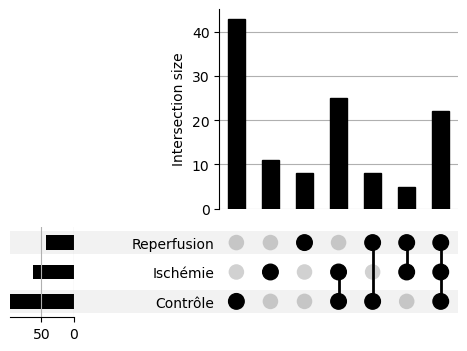

In [11]:
extract_pg = lambda cond: pg_dict[cond]['names'][is_unique_fomonet[cond]]
# Plot the results        
fig = plt.figure(figsize=(10, 10))
upsetplot.plot(upsetplot.from_contents({'Contrôle':extract_pg('ctr'),
                                        'Ischémie':extract_pg('hyp'), 
                                        'Reperfusion':extract_pg('rep')}),
               fig=fig)
fig.savefig(UPSETPLOT, format='svg')

### Query Biomart and make excel file with identified prediction data

In [12]:
# Make lists of all identified FOMOnet predictions
id_request = []
quants_dict = defaultdict(dict)
prots = []
for cond in CONDITIONS:
    # Make clean quantification dict with FOMOnet predictions
    fomonet_pg = pg_dict[cond]['names'][is_unique_fomonet[cond]]
    fomonet_quants = pg_dict[cond]['quants'][is_unique_fomonet[cond]]
    quants_dict[cond] = {pg: quant 
                        for pg, quant in zip(fomonet_pg, fomonet_quants)}
    
    # Id list for Biomart query
    id_request.extend([prot for pg in fomonet_pg for prot in pg.split(';')])

In [13]:
# Get transcript information from biomart
biomart_dict = utils.get_transcript_info(id_request)

In [27]:
keys = ['Protein group', 'Transcript id', 'Associated gene id', 
        'Associated gene name', 'Associated gene biotype', 'ctr', 'hyp', 'rep', 'Condition specific']
tmp_dict = {key: np.nan for key in keys}

res = defaultdict(lambda: copy.deepcopy(tmp_dict))
for cond in CONDITIONS:
    for pg in quants_dict[cond]:
        for prot in pg.split(';'):
            # res[prot].setdefault(copy.deepcopy(tmp_dict))
            res[prot]['Protein group'] = pg
            res[prot][cond] = quants_dict[cond][pg]
            res[prot]['Transcript id'] = prot.split('-')[0]
            # Add biomart information, skip if not found
            try:
                res[prot]['Associated gene id'] = biomart_dict[prot]['Associated gene id']
                res[prot]['Associated gene name'] = biomart_dict[prot]['Associated gene name']
                res[prot]['Associated gene biotype'] = biomart_dict[prot]['Associated gene biotype']
            except KeyError:
                pass

# Check which PG are condition specific
for id_ in res:
    quant = [res[id_][cond] for cond in CONDITIONS] # Get quantification for each condition
    res[id_]['Condition specific'] = np.sum(np.invert(np.isnan(quant))) == 1


In [28]:
df = pd.DataFrame.from_dict(res, orient='index')
df.index.name = 'FOMOnet id'
df.to_excel(IDENTIFIED_XLSX, )

In [30]:
len(np.unique(id_request))

140